# CLASSIFYING MOVIE GENRES BASED ON THEIR POSTERS USING FastAI


This project aims to classify movies into their respective genres based on the movie poster associated with the movie. This project performs dataset generation, processing and model training and evaluation using ResNet-34 as a deep learning and transfer learning method. 

In [1]:
import os
from fastai import *
from fastai.vision import *
from fastai.widgets import *

## Get a list of URLs

Go to Google Images and search for the images we are interested in. 

Scroll down until we've seen all the images we want to download, or until we see a button that says 'Show more results'. All the images we scrolled past are now available to download. To get more, we can click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.


Now we must run some Javascript code in our browser which will save the URLs of all the images we want for our dataset.

Press Ctrl+Shift+J in Windows/Linux and CmdOptJ in Mac to open the 'Console'. Paste the following Javascript command into the window.

Repeat this for each genre category.


## Download images

Now we will need to download our images from their respective urls.

fast.ai has a function that allows us to do just that. We just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

We will need to run code line once for every genre.

In [2]:
folder = 'romance'
file = 'url_romance.txt'

path = Path('D:\Important\SEM 7\AML\project')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(path/file, dest, max_pics=400)

In [3]:
folder = 'horror'
file = 'url_horror.txt'

path = Path('D:\Important\SEM 7\AML\project')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(path/file, dest, max_pics=400)

In [4]:
folder = 'superhero'
file = 'url_superhero.txt'

path = Path('D:\Important\SEM 7\AML\project')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(path/file, dest, max_pics=400)

Then we can remove any images that can't be opened:

In [5]:
classes = ['romance','horror','superhero']
#remove images that can't be opened:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

romance


horror


superhero


## View data

In [6]:
np.random.seed(42)
#setting the percentage of data to be considered as validation set, normalizing data
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

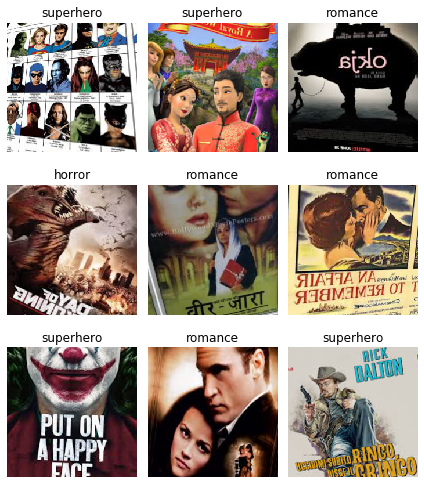

In [7]:
#view data
data.show_batch(rows=3, figsize=(6,7))

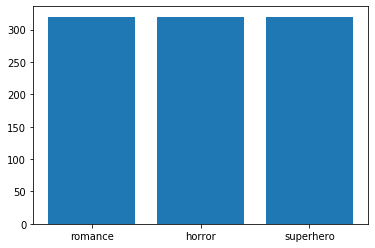

In [8]:
import matplotlib.pyplot as plt
f = []
for c in classes:
    img_folder_path = Path('D:\Important\SEM 7\AML\project\\'+c)
    dirListing = os.listdir(img_folder_path)
    f.append(len(dirListing))

plt.bar(classes, f)
plt.show()

## Train the model

Now that our dataset is ready, we can train the model. We have used pre-trained weights of the ResNet-34 model for transfer learning.

In [9]:
#transfer learning from resNet-34 model
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(4) #4 epochs
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.700358,1.043775,0.614583,04:35
1,1.479514,0.923869,0.671875,04:05
2,1.275974,0.899800,0.661458,04:16
3,1.128807,0.881244,0.645833,03:56


Next we unfreeze the model parameters and calculate the optimal learning rate going forward.

Below we are going to use the “Learning Rate Finder” to find a good learning rate. 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


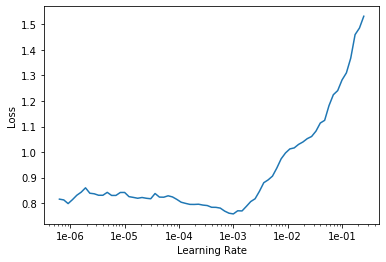

In [10]:
#unfreezing the pre-trained weights
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

Next, we train the whole unfrozen model. This helps fine tune our model down for maximum performance.

In [11]:
#using learning rate obtained by observing the plot
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.847364,0.835529,0.656250,04:33
1,0.708154,0.834357,0.661458,04:54


## Interpretation

We can evaluate our models performance by using it for test inference. Fastai provides a convenient method to visualize our model's confusion matrix.

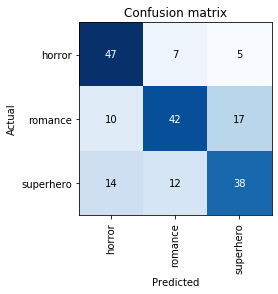

In [12]:
learn.load('stage-2');

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

And we can inspect which images are the hardest for your model to learn.

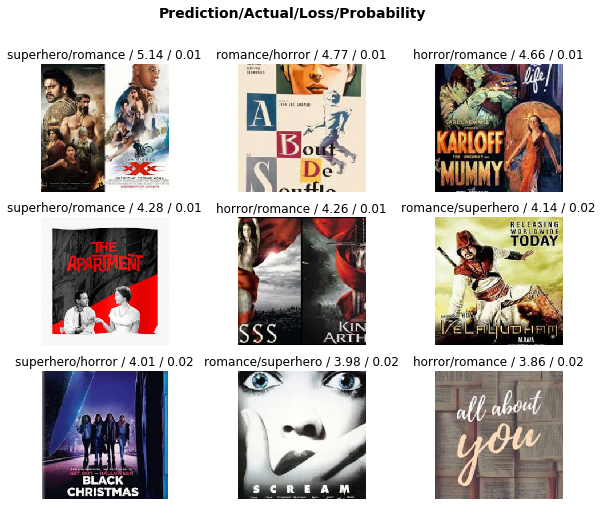

In [13]:
interp.plot_top_losses(9, figsize=(10,8))

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our dataset that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [14]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [15]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

In [16]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [17]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

After we’re done with cleaning, we train the model again to see if there’s any improvement.

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.608916,0.845921,0.677083,04:45
1,0.571435,0.834276,0.677083,04:41


## Testing our classifier

And lastly, we can run a script to run test inference on our test set, images our model has never seen.

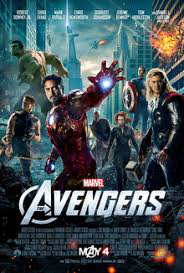

In [20]:
img = open_image('test_image.jpg')
img

In [21]:
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [22]:
learn = cnn_learner(data2, models.resnet34).load('stage-2')
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

superhero
